In [1]:
# Main data packages. 
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset

# Data Viz. 
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

#!pip install pystan==2.17.1.0
#!pip install fbprophet

#!pip install --upgrade plotly
# check prophet version
import fbprophet
# print version number
print('Prophet %s' % fbprophet.__version__)

Importing plotly failed. Interactive plots will not work.


Prophet 0.7.1


In [2]:
# Import data
df = pd.read_csv('../data/meteolytix_Saisonlogik_2021.csv', sep=';')
df.head()

,Sold On,Branch Number,Article Number,Amount Sold,Amount Delivered
0,2012-01-16,100,1,9,20
1,2012-01-17,100,1,14,20
2,2012-01-18,100,1,29,30
3,2012-01-19,100,1,13,15
4,2012-01-20,100,1,14,25


In [3]:
df.drop(columns=['Branch Number'], inplace=True)
df.columns = df.columns.str.replace(' ','_')

# Convert timestamp to datetime object
df['Sold_On']=pd.to_datetime(df['Sold_On'])
# Extract additional features from timestamp column
df = df.assign( 
    Year      = lambda x: x['Sold_On'].dt.year,
    Month     = lambda x: x['Sold_On'].dt.month,
    Week      = lambda x: x['Sold_On'].dt.isocalendar().week,
    WeekDay   = lambda x: x['Sold_On'].dt.dayofweek +1,
    YearDay   = lambda x: x['Sold_On'].dt.dayofyear)

df["Amount_Sold"] = df["Amount_Sold"].str.replace(',','.')
df['Amount_Sold'] = pd.to_numeric(df['Amount_Sold'], errors='coerce')
df['Amount_Sold'] = df['Amount_Sold'].astype(int)

df=df.replace({'Amount_Delivered': {8224: 28}})

# Ratio between Amount Delivered and Amount Sold
df['Ratio_DelSol'] = df['Amount_Delivered'] / df['Amount_Sold']

# Cleanup
# Amount Delivered == 0, in total 19 entries. This lines will be deleted. Not relevant for analysis
#df[df['Ratio_DelSol'].isnull()].index
df = df[~df['Ratio_DelSol'].isnull()]
# Amount Delivered > 0, Amount Sold = 0, in total x entries. Ratio_DelSol replaced with: Amount_Delivered
df[df['Ratio_DelSol']>1000].index
df.loc[list(df[df['Ratio_DelSol']>1000].index), 'Ratio_DelSol'] = df.Amount_Delivered / 1

In [4]:
print(f"The dataset contains:")
print(f"- Entries between {min(df.Sold_On).strftime('%d %B %Y')} and {max(df.Sold_On).strftime('%d %B %Y')}.")
print(f"- {len(df)} entries in total.")
print(f"- {len(df[df['Ratio_DelSol']>1])} entries with: 'Amount_Delivered' > 'Amount Sold'. Assumption: 'Overdelivery', money lost.")
print(f"- {len(df[df['Ratio_DelSol']==1])} entries with: 'Amount Delivered' = 'Amount Sold'. Assumption: 'Underdelivery', potentially less money made.")
print(f"- {len(df[df['Ratio_DelSol']<1])} entries with:  'Amount Delivered' < 'Amount Sold'. Assumption: 'Underdelivery', potentially less money made.")

The dataset contains:
- Entries between 02 January 2012 and 14 April 2021.
- 5373 entries in total.
- 3054 entries with: 'Amount_Delivered' > 'Amount Sold'. Assumption: 'Overdelivery', money lost.
- 2046 entries with: 'Amount Delivered' = 'Amount Sold'. Assumption: 'Underdelivery', potentially less money made.
- 273 entries with:  'Amount Delivered' < 'Amount Sold'. Assumption: 'Underdelivery', potentially less money made.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5373 entries, 0 to 5391
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Sold_On           5373 non-null   datetime64[ns]
 1   Article_Number    5373 non-null   int64         
 2   Amount_Sold       5373 non-null   int64         
 3   Amount_Delivered  5373 non-null   int64         
 4   Year              5373 non-null   int64         
 5   Month             5373 non-null   int64         
 6   Week              5373 non-null   UInt32        
 7   WeekDay           5373 non-null   int64         
 8   YearDay           5373 non-null   int64         
 9   Ratio_DelSol      5373 non-null   float64       
dtypes: UInt32(1), datetime64[ns](1), float64(1), int64(7)
memory usage: 575.0 KB


In [6]:
df[df['Article_Number']==1].describe()

,Article_Number,Amount_Sold,Amount_Delivered,Year,Month,Week,WeekDay,YearDay,Ratio_DelSol
count,992.0,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000
mean,1.0,71.137097,77.444556,2016.465726,2.683468,10.005040,3.989919,66.904234,1.103829
std,0.0,32.490461,35.889096,2.880891,1.019789,4.204531,1.991885,29.249680,0.262304
min,1.0,1.000000,0.000000,2012.000000,1.000000,2.000000,1.000000,13.000000,0.000000
25%,1.0,46.000000,50.000000,2014.000000,2.000000,6.000000,2.000000,42.000000,1.000000
50%,1.0,66.000000,73.000000,2016.000000,3.000000,10.000000,4.000000,67.000000,1.028037
75%,1.0,92.000000,100.000000,2019.000000,4.000000,14.000000,6.000000,92.000000,1.141964
max,1.0,203.000000,235.000000,2021.000000,5.000000,18.000000,7.000000,123.000000,6.600000


In [7]:
df[(df['Article_Number']==1)&(df['Ratio_DelSol']>1)].describe()

,Article_Number,Amount_Sold,Amount_Delivered,Year,Month,Week,WeekDay,YearDay,Ratio_DelSol
count,653.0,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000
mean,1.0,74.081164,84.442573,2016.735069,2.699847,10.071975,3.926493,67.283308,1.170595
std,0.0,33.464721,36.953401,2.922088,1.037022,4.271754,1.959119,29.768240,0.294110
min,1.0,9.000000,15.000000,2012.000000,1.000000,2.000000,1.000000,13.000000,1.006289
25%,1.0,49.000000,56.000000,2014.000000,2.000000,6.000000,2.000000,41.000000,1.029412
50%,1.0,69.000000,80.000000,2017.000000,3.000000,10.000000,4.000000,69.000000,1.083333
75%,1.0,96.000000,105.000000,2019.000000,4.000000,14.000000,6.000000,92.000000,1.224490
max,1.0,203.000000,235.000000,2021.000000,5.000000,18.000000,7.000000,123.000000,6.600000


In [8]:
df.groupby('Article_Number').Amount_Sold.count()

Article_Number
1     992
2    2202
3    2179
Name: Amount_Sold, dtype: int64

In [9]:
# Assumed Selling Prices
Sell_Price_Article_1 = 1.4
Sell_Price_Article_2 = 1.4
Sell_Price_Article_3 = 1.4

# Assumed Total Production Costs: 8% Location rental, 
# 17% Production, 20% Personal -> 45 %. 1.4 * 0.45 = 0.63
Prod_Cost_Article_1 = 0.63
Prod_Cost_Article_2 = 0.63
Prod_Cost_Article_3 = 0.63

# Assumed increase of Sellings
Underdelivery_increase = 1.05

# Assumed decrease of Overdeliverys
Overdelivery_decrease = 1.1

In [10]:
#df_Total=df[df['Year']==2021].groupby('Article_Number').Amount_Sold.sum().to_frame()
#df_Total['Amount_Delivered']=df[df['Year']==2021].groupby('Article_Number').Amount_Delivered.sum()
df_Total=df.groupby('Article_Number').Amount_Sold.sum().to_frame()
df_Total['Amount_Delivered']=df.groupby('Article_Number').Amount_Delivered.sum()

df_Total['Amount_Discarded']=df_Total['Amount_Delivered']-df_Total['Amount_Sold']
df_Total['Discard_Rate']=df_Total['Amount_Delivered']/df_Total['Amount_Sold']
df_Total['Sell_Price']=[Sell_Price_Article_1, Sell_Price_Article_2, Sell_Price_Article_3]
df_Total['Prod_Cost'] =[Prod_Cost_Article_1, Prod_Cost_Article_1, Prod_Cost_Article_1] 
df_Total['Discarded']=df_Total['Amount_Discarded']*df_Total['Prod_Cost']
df_Total['Revenue']=df_Total['Amount_Sold']*df_Total['Sell_Price']
df_Total['Cost']=df_Total['Amount_Delivered']*df_Total['Prod_Cost']
df_Total['Profit']=df_Total['Revenue']-df_Total['Cost']
df_Total['Profitability']=df_Total['Profit']/df_Total['Cost']

df_Total = df_Total.transpose()
df_Total.index.name = None

#df_Total['RDS>1']=df[df['Ratio_DelSol']>1].groupby('Article_Number').Amount_Delivered.count()
#df_Total['RDS=1']=df[df['Ratio_DelSol']==1].groupby('Article_Number').Amount_Delivered.count()
#df_Total['RDS<1']=df[df['Ratio_DelSol']<1].groupby('Article_Number').Amount_Delivered.count()
df_Total["Total"] = df_Total.sum(axis = 1, skipna = True)
df_Total["Unit"] = ['[-]','[-]','[-]','[-]','[€]','[€]','[€]','[€]','[€]','[€]','[-]']
df_Total.Total.Profitability = df_Total.Total.Profitability / 3
df_Total.Total.Discard_Rate = df_Total.Total.Discard_Rate / 3
df_Total.Total.Sell_Price = df_Total.Total.Sell_Price / 3
df_Total.Total.Prod_Cost = df_Total.Total.Prod_Cost / 3

df_Total=df_Total.round(2)

df_Total.head(20)

/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Article_Number,1,2,3,Total,Unit
Amount_Sold,70568.00,39091.00,20393.00,130052.00,[-]
Amount_Delivered,76825.00,45063.00,23979.00,145867.00,[-]
Amount_Discarded,6257.00,5972.00,3586.00,15815.00,[-]
Discard_Rate,1.09,1.15,1.18,1.14,[-]
Sell_Price,1.40,1.40,1.40,1.40,[€]
Prod_Cost,0.63,0.63,0.63,0.63,[€]
Discarded,3941.91,3762.36,2259.18,9963.45,[€]
Revenue,98795.20,54727.40,28550.20,182072.80,[€]
Cost,48399.75,28389.69,15106.77,91896.21,[€]
Profit,50395.45,26337.71,13443.43,90176.59,[€]


In [11]:
# Basis Calculation, Status "as it is"
df_Delivered_Y = pd.pivot_table(data=df,index='Year', columns='Article_Number', values='Amount_Delivered', aggfunc='sum')
df_Sold_Y = pd.pivot_table(data=df,index='Year', columns='Article_Number', values='Amount_Sold', aggfunc='sum')
df_Revenue_Y = df_Sold_Y.mul([Sell_Price_Article_1, Sell_Price_Article_2, Sell_Price_Article_3], axis=1)
df_Cost_Y = df_Delivered_Y.mul([Prod_Cost_Article_1, Prod_Cost_Article_1, Prod_Cost_Article_1], axis=1)
df_Profit_Y = df_Revenue_Y - df_Cost_Y
df_Profitability_Y = df_Profit_Y / df_Cost_Y

df_Delivered_M = pd.pivot_table(data=df,index='Month', columns='Article_Number', values='Amount_Delivered', aggfunc='sum')
df_Sold_M = pd.pivot_table(data=df,index='Month', columns='Article_Number', values='Amount_Sold', aggfunc='sum')
df_Revenue_M = df_Sold_M.mul([Sell_Price_Article_1, Sell_Price_Article_2, Sell_Price_Article_3], axis=1)
df_Cost_M = df_Delivered_M.mul([Prod_Cost_Article_1, Prod_Cost_Article_1, Prod_Cost_Article_1], axis=1)
df_Profit_M = df_Revenue_M - df_Cost_M
df_Profitability_M = df_Profit_M / df_Cost_M

df_Delivered_D = pd.pivot_table(data=df,index='WeekDay', columns='Article_Number', values='Amount_Delivered', aggfunc='sum')
df_Sold_D = pd.pivot_table(data=df,index='WeekDay', columns='Article_Number', values='Amount_Sold', aggfunc='sum')
df_Revenue_D = df_Sold_D.mul([Sell_Price_Article_1, Sell_Price_Article_2, Sell_Price_Article_3], axis=1)
df_Cost_D = df_Delivered_D.mul([Prod_Cost_Article_1, Prod_Cost_Article_1, Prod_Cost_Article_1], axis=1)
df_Profit_D = df_Revenue_D - df_Cost_D
df_Profitability_D = df_Profit_D / df_Cost_D

#df_Delivered['Total']     = df_Delivered.sum(axis=1)
#df_Sold['Total']          = df_Sold.sum(axis=1)
#df_Revenue['Total']       = df_Revenue.sum(axis=1)
#df_Cost['Total']          = df_Cost.sum(axis=1)
#df_Profit['Total']        = df_Profit.sum(axis=1)
#df_Profitability['Total'] = df_Profitability.sum(axis=1) / len(df_Profitability.columns) 
df_Profitability_M.head(10)


Article_Number,1,2,3
Month,,,
1,1.053545,1.014229,0.988304
2,1.016439,0.955422,0.902879
3,1.057886,0.861972,0.799146
4,1.035800,0.875031,0.784356
5,0.898990,0.811141,0.933830
6,NaN,0.862012,0.844532
7,NaN,1.103175,0.666667
9,NaN,1.049957,1.047138
10,NaN,0.974719,0.980442


([<matplotlib.axis.XTick at 0x7faa18027df0>,
 [Text(-2.5, 0, '−2.5'),
  Text(0.0, 0, '0.0'),
  Text(2.5, 0, '2.5'),
  Text(5.0, 0, '5.0')])

<Figure size 600x400 with 0 Axes>

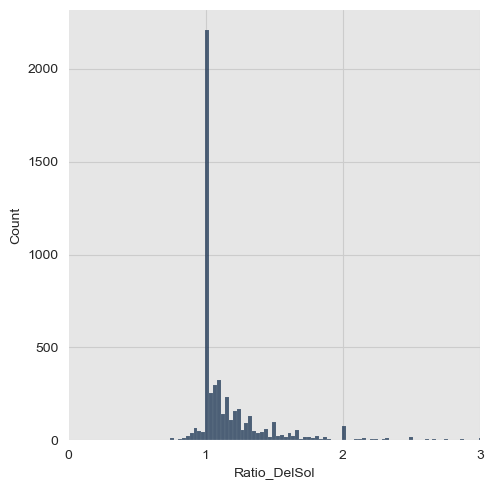

In [12]:
plt.figure(figsize = (6,4))
sns.displot(df['Ratio_DelSol'])
plt.xlim([0,3])
plt.xticks([0,1,2,3])

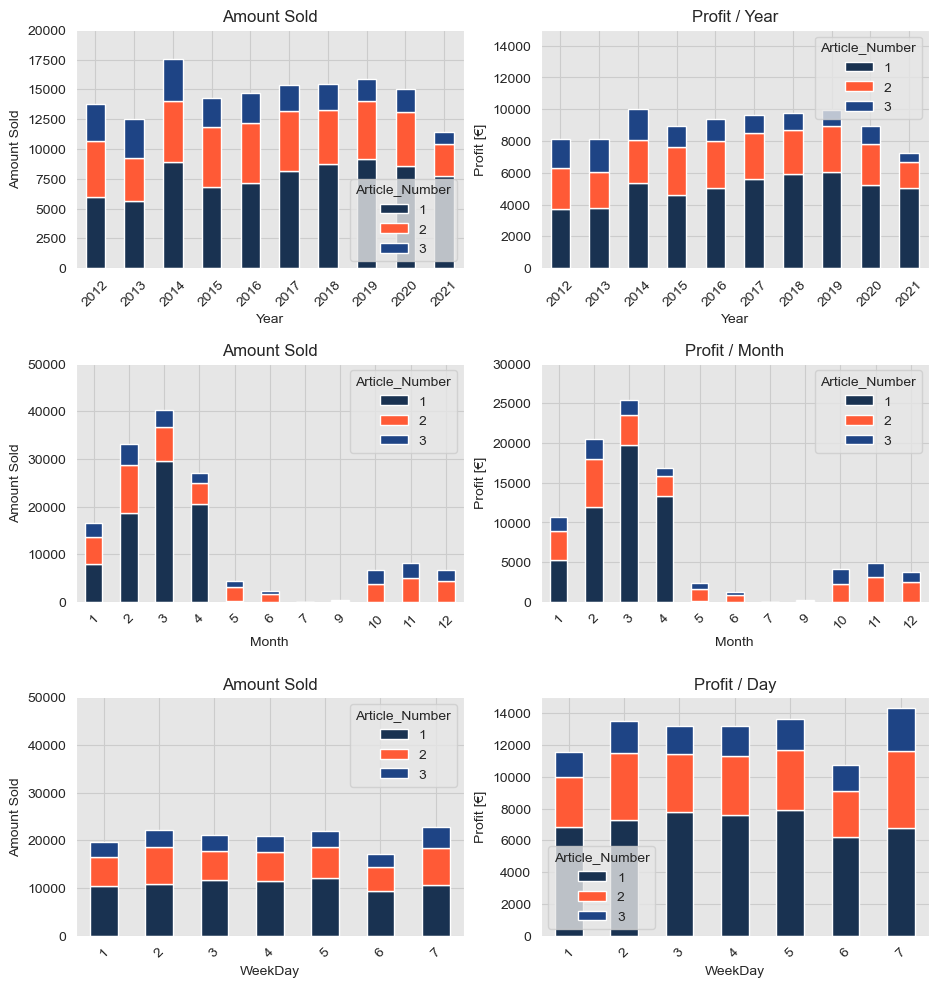

In [13]:
# Plotting
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(11,12))

# Year
df_Delivered_Y.plot(kind='bar', ax=ax1, title = 'Amount Sold', stacked=True, ylabel='Amount Sold', ylim=[0,20000], rot=45)
df_Profit_Y.plot(kind='bar', ax=ax2, title = 'Profit / Year', stacked=True, ylabel='Profit [€]', ylim=[0,15000], rot=45)
df_Delivered_M.plot(kind='bar', ax=ax3, title = 'Amount Sold', stacked=True, ylabel='Amount Sold', ylim=[0,50000], rot=45)
df_Profit_M.plot(kind='bar', ax=ax4, title = 'Profit / Month', stacked=True, ylabel='Profit [€]', ylim=[0,30000], rot=45)
df_Delivered_D.plot(kind='bar', ax=ax5, title = 'Amount Sold', stacked=True, ylabel='Amount Sold', ylim=[0,50000], rot=45)
df_Profit_D.plot(kind='bar', ax=ax6, title = 'Profit / Day', stacked=True, ylabel='Profit [€]', ylim=[0,15000], rot=45)

fig.subplots_adjust(hspace=0.4)
plt.show()

(0.0, 200.0)

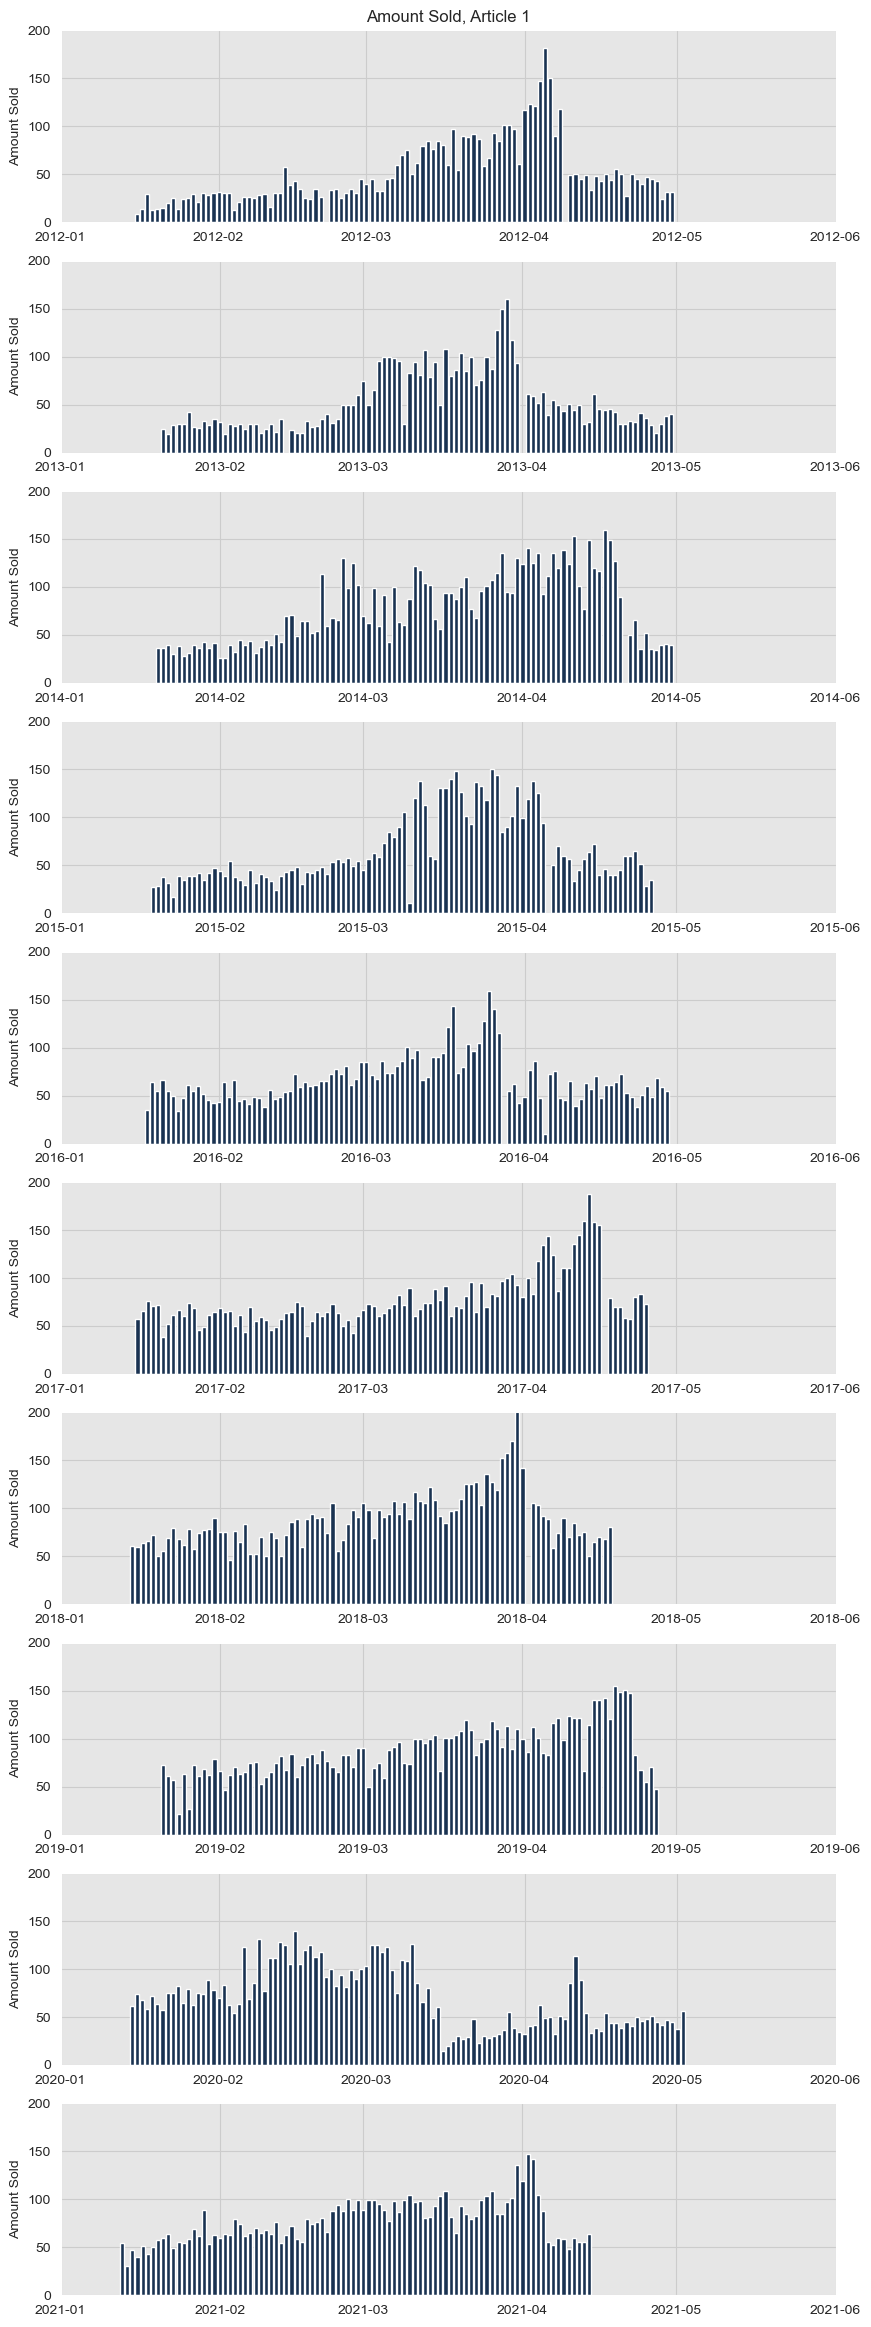

In [14]:
# Plotting Amount Sold for Article 1 for all years
fig, ((ax1), (ax2), (ax3), (ax4), (ax5), (ax6), (ax7), (ax8), (ax9), (ax10)) = plt.subplots(10, 1, figsize=(10,30))

df_tmp = df[(df['Article_Number']==1) & (df['Ratio_DelSol']>0)]

ax1.bar(df_tmp[(df_tmp['Year']==2012)].Sold_On, df_tmp[(df_tmp['Year']==2012)].Amount_Sold, width=0.8)
ax1.set_xlim(pd.Timestamp('2012-01-01'), pd.Timestamp('2012-06-01'))
ax1.set_ylabel('Amount Sold')
ax1.set_ylim(0,200)
ax1.set_title('Amount Sold, Article 1')

ax2.bar(df_tmp[(df_tmp['Year']==2013)].Sold_On, df_tmp[(df_tmp['Year']==2013)].Amount_Sold, width=0.8)
ax2.set_xlim(pd.Timestamp('2013-01-01'), pd.Timestamp('2013-06-01'))
ax2.set_ylabel('Amount Sold')
ax2.set_ylim(0,200)

ax3.bar(df_tmp[(df_tmp['Year']==2014)].Sold_On, df_tmp[(df_tmp['Year']==2014)].Amount_Sold, width=0.8)
ax3.set_xlim(pd.Timestamp('2014-01-01'), pd.Timestamp('2014-06-01'))
ax3.set_ylabel('Amount Sold')
ax3.set_ylim(0,200)

ax4.bar(df_tmp[(df_tmp['Year']==2015)].Sold_On, df_tmp[(df_tmp['Year']==2015)].Amount_Sold, width=0.8)
ax4.set_xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2015-06-01'))
ax4.set_ylabel('Amount Sold')
ax4.set_ylim(0,200)

ax5.bar(df_tmp[(df_tmp['Year']==2016)].Sold_On, df_tmp[(df_tmp['Year']==2016)].Amount_Sold, width=0.8)
ax5.set_xlim(pd.Timestamp('2016-01-01'), pd.Timestamp('2016-06-01'))
ax5.set_ylabel('Amount Sold')
ax5.set_ylim(0,200)

ax6.bar(df_tmp[(df_tmp['Year']==2017)].Sold_On, df_tmp[(df_tmp['Year']==2017)].Amount_Sold, width=0.8)
ax6.set_xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2017-06-01'))
ax6.set_ylabel('Amount Sold')
ax6.set_ylim(0,200)

ax7.bar(df_tmp[(df_tmp['Year']==2018)].Sold_On, df_tmp[(df_tmp['Year']==2018)].Amount_Sold, width=0.8)
ax7.set_xlim(pd.Timestamp('2018-01-01'), pd.Timestamp('2018-06-01'))
ax7.set_ylabel('Amount Sold')
ax7.set_ylim(0,200)

ax8.bar(df_tmp[(df_tmp['Year']==2019)].Sold_On, df_tmp[(df_tmp['Year']==2019)].Amount_Sold, width=0.8)
ax8.set_xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2019-06-01'))
ax8.set_ylabel('Amount Sold')
ax8.set_ylim(0,200)

ax9.bar(df_tmp[(df_tmp['Year']==2020)].Sold_On, df_tmp[(df_tmp['Year']==2020)].Amount_Sold, width=0.8)
ax9.set_xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2020-06-01'))
ax9.set_ylabel('Amount Sold')
ax9.set_ylim(0,200)

ax10.bar(df_tmp[(df_tmp['Year']==2021)].Sold_On, df_tmp[(df_tmp['Year']==2021)].Amount_Sold, width=0.8)
ax10.set_xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2021-06-01'))
ax10.set_ylabel('Amount Sold')
ax10.set_ylim(0,200)

In [15]:
#2021-04-05 Ostermontag <- Reference for test (+0)
#2020-04-13 Ostermontag <- Due to Corona 2020 is neglected
df_base = df[(df['Article_Number']==1) & (df['Year']!=2020)& (df['Year']!=2021)].copy()
df_base.loc[df_base.Year == 2019, 'Sold_On'] = df_base.loc[df_base.Year == 2019, 'Sold_On'] + DateOffset(years=2, days = -17) #2019-04-22 Ostermontag
df_base.loc[df_base.Year == 2018, 'Sold_On'] = df_base.loc[df_base.Year == 2018, 'Sold_On'] + DateOffset(years=3, days = +3)  #2018-04-02 Ostermontag 
df_base.loc[df_base.Year == 2017, 'Sold_On'] = df_base.loc[df_base.Year == 2017, 'Sold_On'] + DateOffset(years=4, days = -12) #2017-04-17 Ostermontag
df_base.loc[df_base.Year == 2016, 'Sold_On'] = df_base.loc[df_base.Year == 2016, 'Sold_On'] + DateOffset(years=5, days = +8)  #2016-03-28 Ostermontag
df_base.loc[df_base.Year == 2015, 'Sold_On'] = df_base.loc[df_base.Year == 2015, 'Sold_On'] + DateOffset(years=6, days = -1)  #2015-04-06 Ostermontag
df_base.loc[df_base.Year == 2014, 'Sold_On'] = df_base.loc[df_base.Year == 2014, 'Sold_On'] + DateOffset(years=7, days = -16) #2014-04-21 Ostermontag
df_base.loc[df_base.Year == 2013, 'Sold_On'] = df_base.loc[df_base.Year == 2013, 'Sold_On'] + DateOffset(years=8, days = +4)  #2013-04-01 Ostermontag
df_base.loc[df_base.Year == 2012, 'Sold_On'] = df_base.loc[df_base.Year == 2012, 'Sold_On'] + DateOffset(years=9, days = -4)  #2012-04-09 Ostermontag

# Pivoting
df_base=pd.pivot_table(data=df_base,index='Sold_On', columns='Year', values='Amount_Sold', aggfunc='sum')

# Check median or mean
#df_base['predicted']=df_base.median(axis=1)
df_base['2021_predicted']=df_base.mean(axis=1)
display(df_base.head())

df_2021_test = df[(df['Article_Number']==1)&(df['Year']==2021)][['Sold_On', 'Amount_Sold']].set_index('Sold_On')

df_base = pd.concat([df_base[['2021_predicted']], df_2021_test], axis=1)
df_base.rename(columns = {'Amount_Sold': '2021_test'}, inplace = True)

df_base.head()

Year,2012,2013,2014,2015,2016,2017,2018,2019,2021_predicted
Sold_On,,,,,,,,,
2021-01-04,NaN,NaN,36.0,NaN,NaN,57.0,NaN,73.0,55.333333
2021-01-05,NaN,NaN,36.0,NaN,NaN,66.0,NaN,61.0,54.333333
2021-01-06,NaN,NaN,40.0,NaN,NaN,76.0,NaN,57.0,57.666667
2021-01-07,NaN,NaN,30.0,NaN,NaN,71.0,NaN,21.0,40.666667
2021-01-08,NaN,NaN,38.0,NaN,NaN,72.0,NaN,63.0,57.666667


,2021_predicted,2021_test
Sold_On,,
2021-01-04,55.333333,NaN
2021-01-05,54.333333,NaN
2021-01-06,57.666667,NaN
2021-01-07,40.666667,NaN
2021-01-08,57.666667,NaN


[Text(0, 0, '2021-01-04 00:00:00'),
 Text(1, 0, ''),
 Text(2, 0, ''),
 Text(3, 0, ''),
 Text(4, 0, ''),
 Text(5, 0, '2021-01-09 00:00:00'),
 Text(6, 0, ''),
 Text(7, 0, ''),
 Text(8, 0, ''),
 Text(9, 0, ''),
 Text(10, 0, '2021-01-14 00:00:00'),
 Text(11, 0, ''),
 Text(12, 0, ''),
 Text(13, 0, ''),
 Text(14, 0, ''),
 Text(15, 0, '2021-01-19 00:00:00'),
 Text(16, 0, ''),
 Text(17, 0, ''),
 Text(18, 0, ''),
 Text(19, 0, ''),
 Text(20, 0, '2021-01-24 00:00:00'),
 Text(21, 0, ''),
 Text(22, 0, ''),
 Text(23, 0, ''),
 Text(24, 0, ''),
 Text(25, 0, '2021-01-29 00:00:00'),
 Text(26, 0, ''),
 Text(27, 0, ''),
 Text(28, 0, ''),
 Text(29, 0, ''),
 Text(30, 0, '2021-02-03 00:00:00'),
 Text(31, 0, ''),
 Text(32, 0, ''),
 Text(33, 0, ''),
 Text(34, 0, ''),
 Text(35, 0, '2021-02-08 00:00:00'),
 Text(36, 0, ''),
 Text(37, 0, ''),
 Text(38, 0, ''),
 Text(39, 0, ''),
 Text(40, 0, '2021-02-13 00:00:00'),
 Text(41, 0, ''),
 Text(42, 0, ''),
 Text(43, 0, ''),
 Text(44, 0, ''),
 Text(45, 0, '2021-02-18 00:0

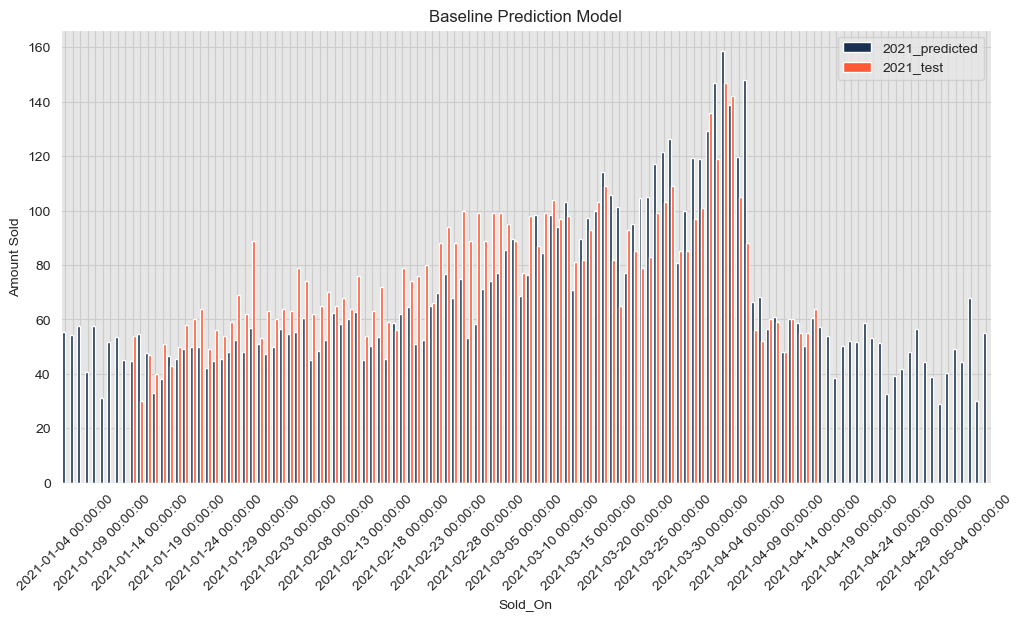

In [16]:
ax2 = df_base.plot.bar(rot=45, width=0.8, ylabel='Amount Sold')
ax2.set_title('Baseline Prediction Model')
ax2.set_xticklabels([t if not i%5 else "" for i, t in enumerate(ax2.get_xticklabels())])

In [17]:
#result['AbsError']=(np.abs(result.average-result.test)/result.test)*100
#result['AbsError'].mean()

In [18]:
#error with all features,       2012-2019: 17.40
#error with all features,       2014-2019: 14.71
#error with delsol !=1          2014-2019: 16.38
#error with delsol >1           2014-2019: 16.41
#error with delsol >1                2019: 16.41

(0.0, 1.5)

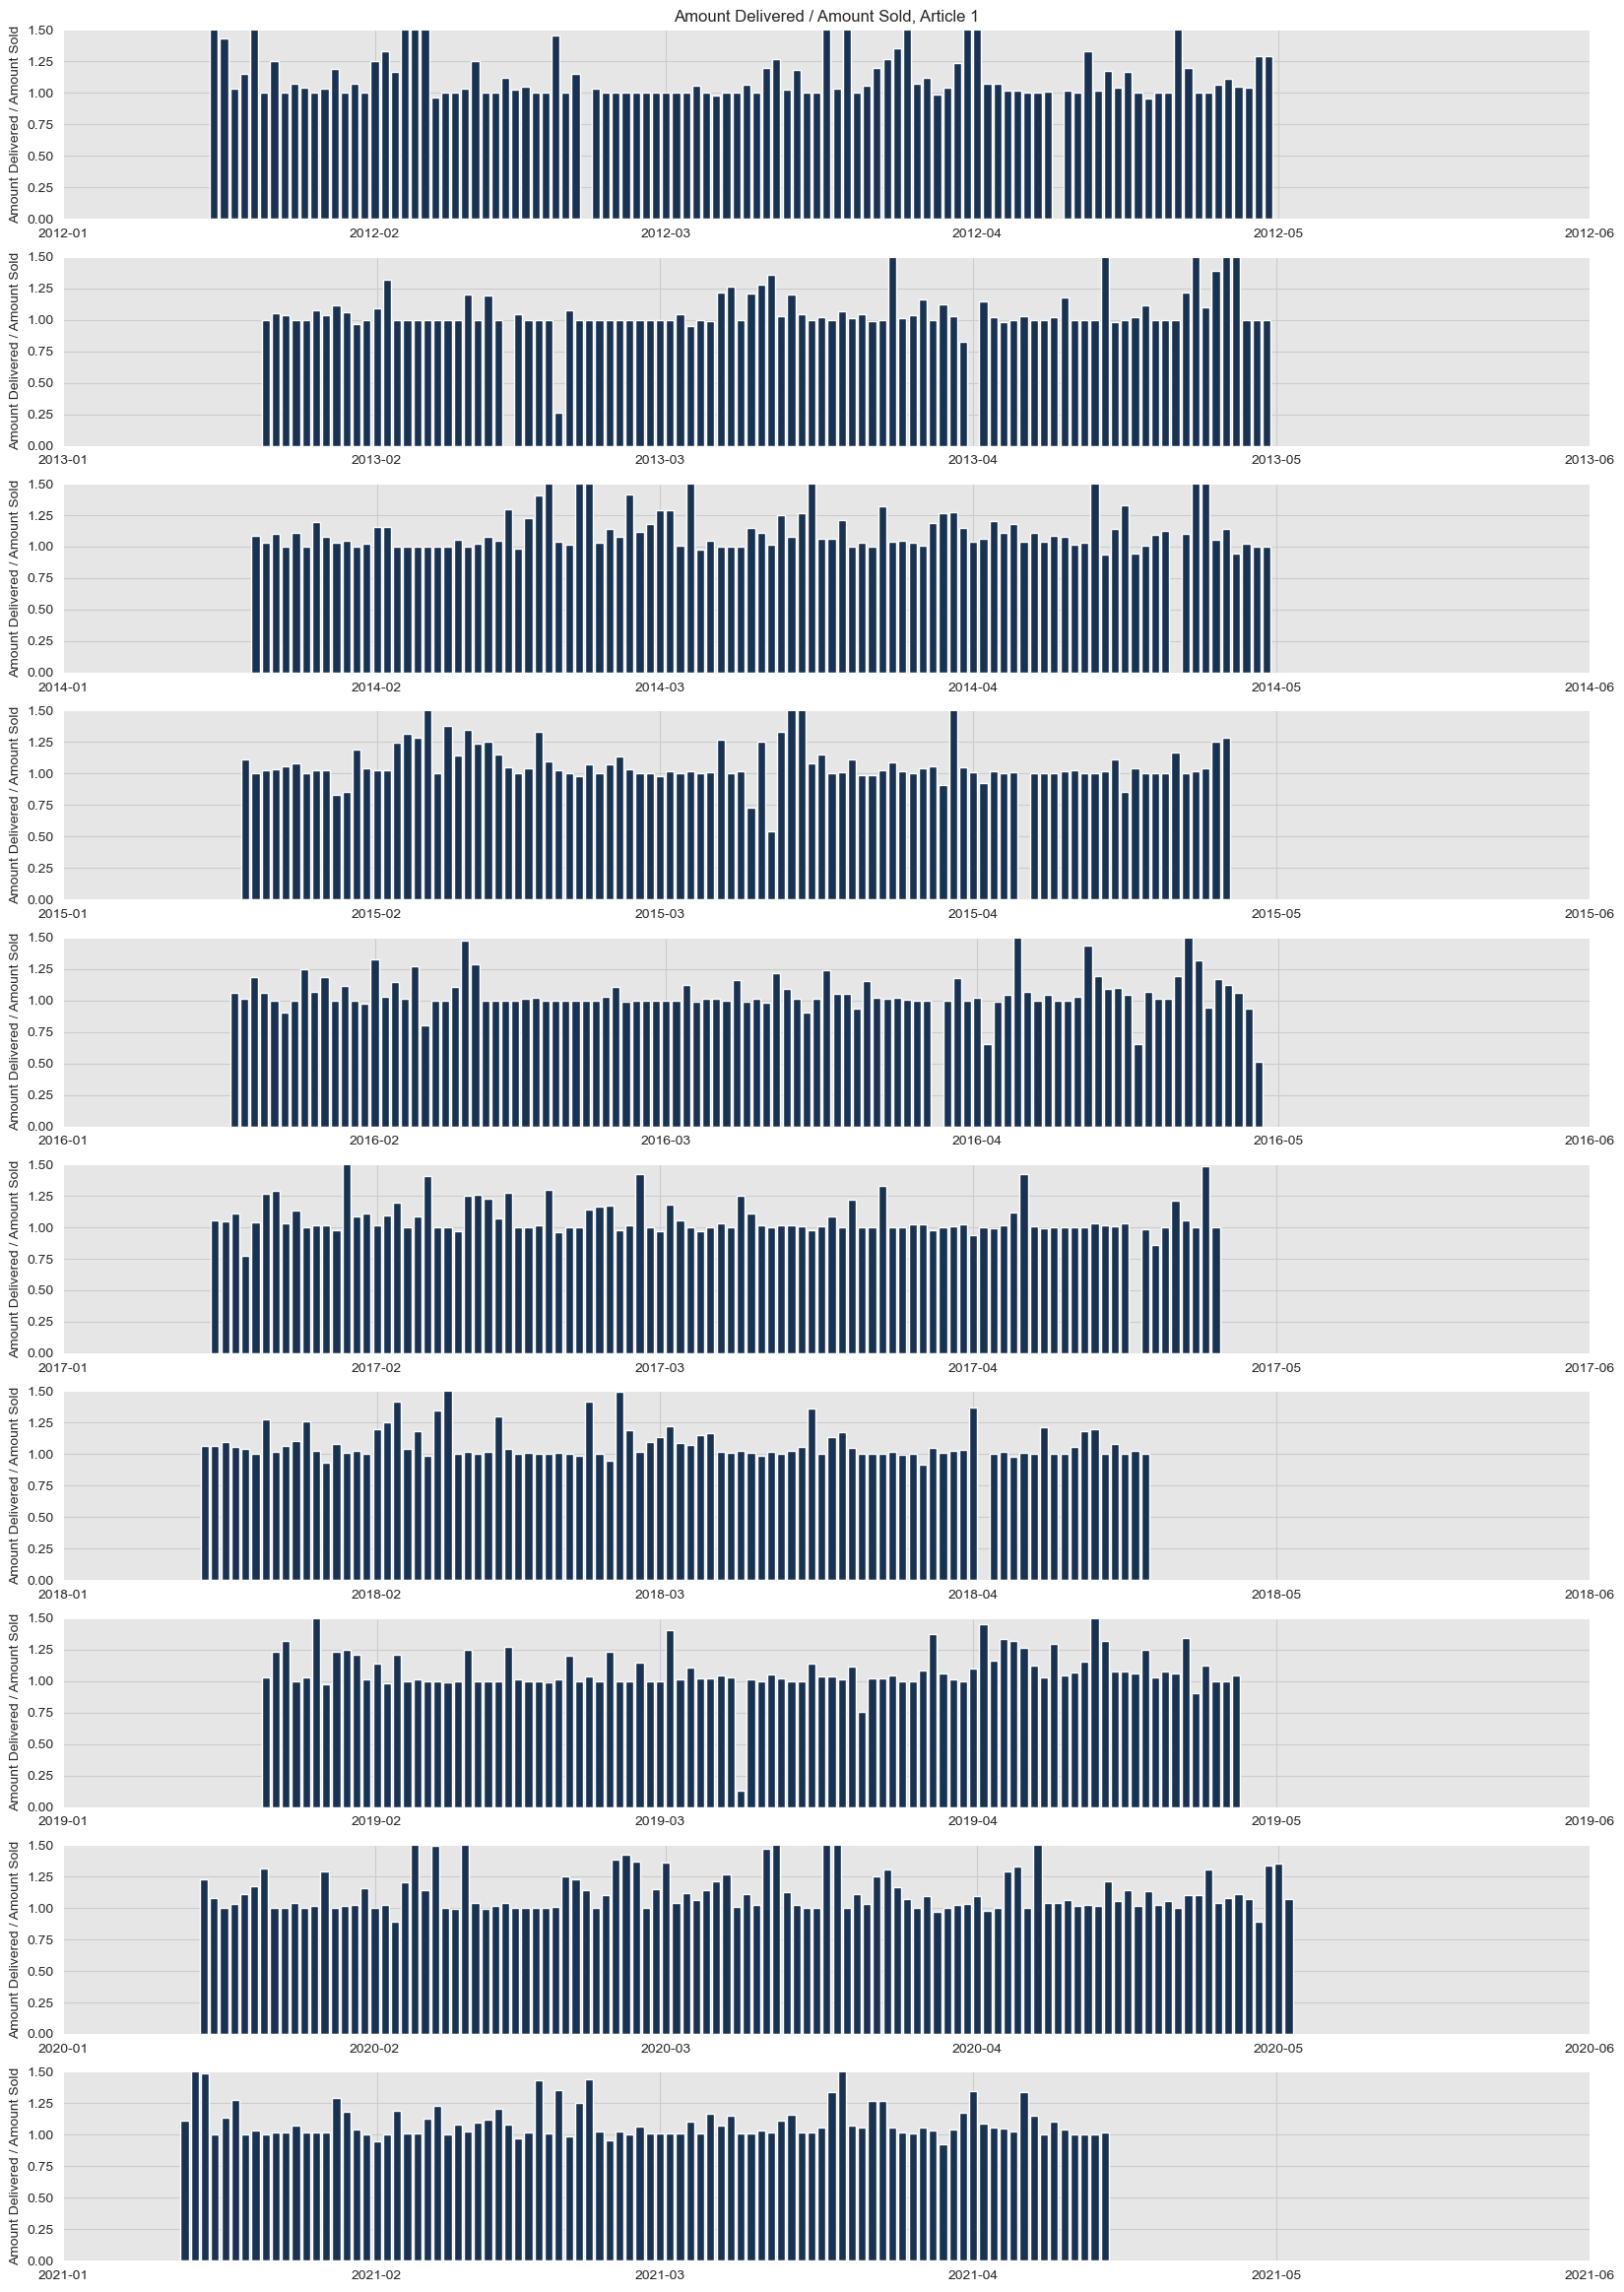

In [19]:
# Plotting Amount Sold for Article 1 for all years
fig, ((ax1), (ax2), (ax3), (ax4), (ax5), (ax6), (ax7), (ax8), (ax9), (ax10)) = plt.subplots(10, 1, figsize=(20,30))

df_tmp = df[(df['Article_Number']==1) & (df['Ratio_DelSol']>0)]

ax1.bar(df_tmp[(df_tmp['Year']==2012)].Sold_On, df_tmp[(df_tmp['Year']==2012)].Ratio_DelSol, width=0.8)
ax1.set_xlim(pd.Timestamp('2012-01-01'), pd.Timestamp('2012-06-01'))
ax1.set_ylabel('Amount Delivered / Amount Sold')
ax1.set_ylim(0,1.5)
ax1.set_title('Amount Delivered / Amount Sold, Article 1')

ax2.bar(df_tmp[(df_tmp['Year']==2013)].Sold_On, df_tmp[(df_tmp['Year']==2013)].Ratio_DelSol, width=0.8)
ax2.set_xlim(pd.Timestamp('2013-01-01'), pd.Timestamp('2013-06-01'))
ax2.set_ylabel('Amount Delivered / Amount Sold')
ax2.set_ylim(0,1.5)

ax3.bar(df_tmp[(df_tmp['Year']==2014)].Sold_On, df_tmp[(df_tmp['Year']==2014)].Ratio_DelSol, width=0.8)
ax3.set_xlim(pd.Timestamp('2014-01-01'), pd.Timestamp('2014-06-01'))
ax3.set_ylabel('Amount Delivered / Amount Sold')
ax3.set_ylim(0,1.5)

ax4.bar(df_tmp[(df_tmp['Year']==2015)].Sold_On, df_tmp[(df_tmp['Year']==2015)].Ratio_DelSol, width=0.8)
ax4.set_xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2015-06-01'))
ax4.set_ylabel('Amount Delivered / Amount Sold')
ax4.set_ylim(0,1.5)

ax5.bar(df_tmp[(df_tmp['Year']==2016)].Sold_On, df_tmp[(df_tmp['Year']==2016)].Ratio_DelSol, width=0.8)
ax5.set_xlim(pd.Timestamp('2016-01-01'), pd.Timestamp('2016-06-01'))
ax5.set_ylabel('Amount Delivered / Amount Sold')
ax5.set_ylim(0,1.5)

ax6.bar(df_tmp[(df_tmp['Year']==2017)].Sold_On, df_tmp[(df_tmp['Year']==2017)].Ratio_DelSol, width=0.8)
ax6.set_xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2017-06-01'))
ax6.set_ylabel('Amount Delivered / Amount Sold')
ax6.set_ylim(0,1.5)

ax7.bar(df_tmp[(df_tmp['Year']==2018)].Sold_On, df_tmp[(df_tmp['Year']==2018)].Ratio_DelSol, width=0.8)
ax7.set_xlim(pd.Timestamp('2018-01-01'), pd.Timestamp('2018-06-01'))
ax7.set_ylabel('Amount Delivered / Amount Sold')
ax7.set_ylim(0,1.5)

ax8.bar(df_tmp[(df_tmp['Year']==2019)].Sold_On, df_tmp[(df_tmp['Year']==2019)].Ratio_DelSol, width=0.8)
ax8.set_xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2019-06-01'))
ax8.set_ylabel('Amount Delivered / Amount Sold')
ax8.set_ylim(0,1.5)

ax9.bar(df_tmp[(df_tmp['Year']==2020)].Sold_On, df_tmp[(df_tmp['Year']==2020)].Ratio_DelSol, width=0.8)
ax9.set_xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2020-06-01'))
ax9.set_ylabel('Amount Delivered / Amount Sold')
ax9.set_ylim(0,1.5)

ax10.bar(df_tmp[(df_tmp['Year']==2021)].Sold_On, df_tmp[(df_tmp['Year']==2021)].Ratio_DelSol, width=0.8)
ax10.set_xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2021-06-01'))
ax10.set_ylabel('Amount Delivered / Amount Sold')
ax10.set_ylim(0,1.5)

(0.0, 100.0)

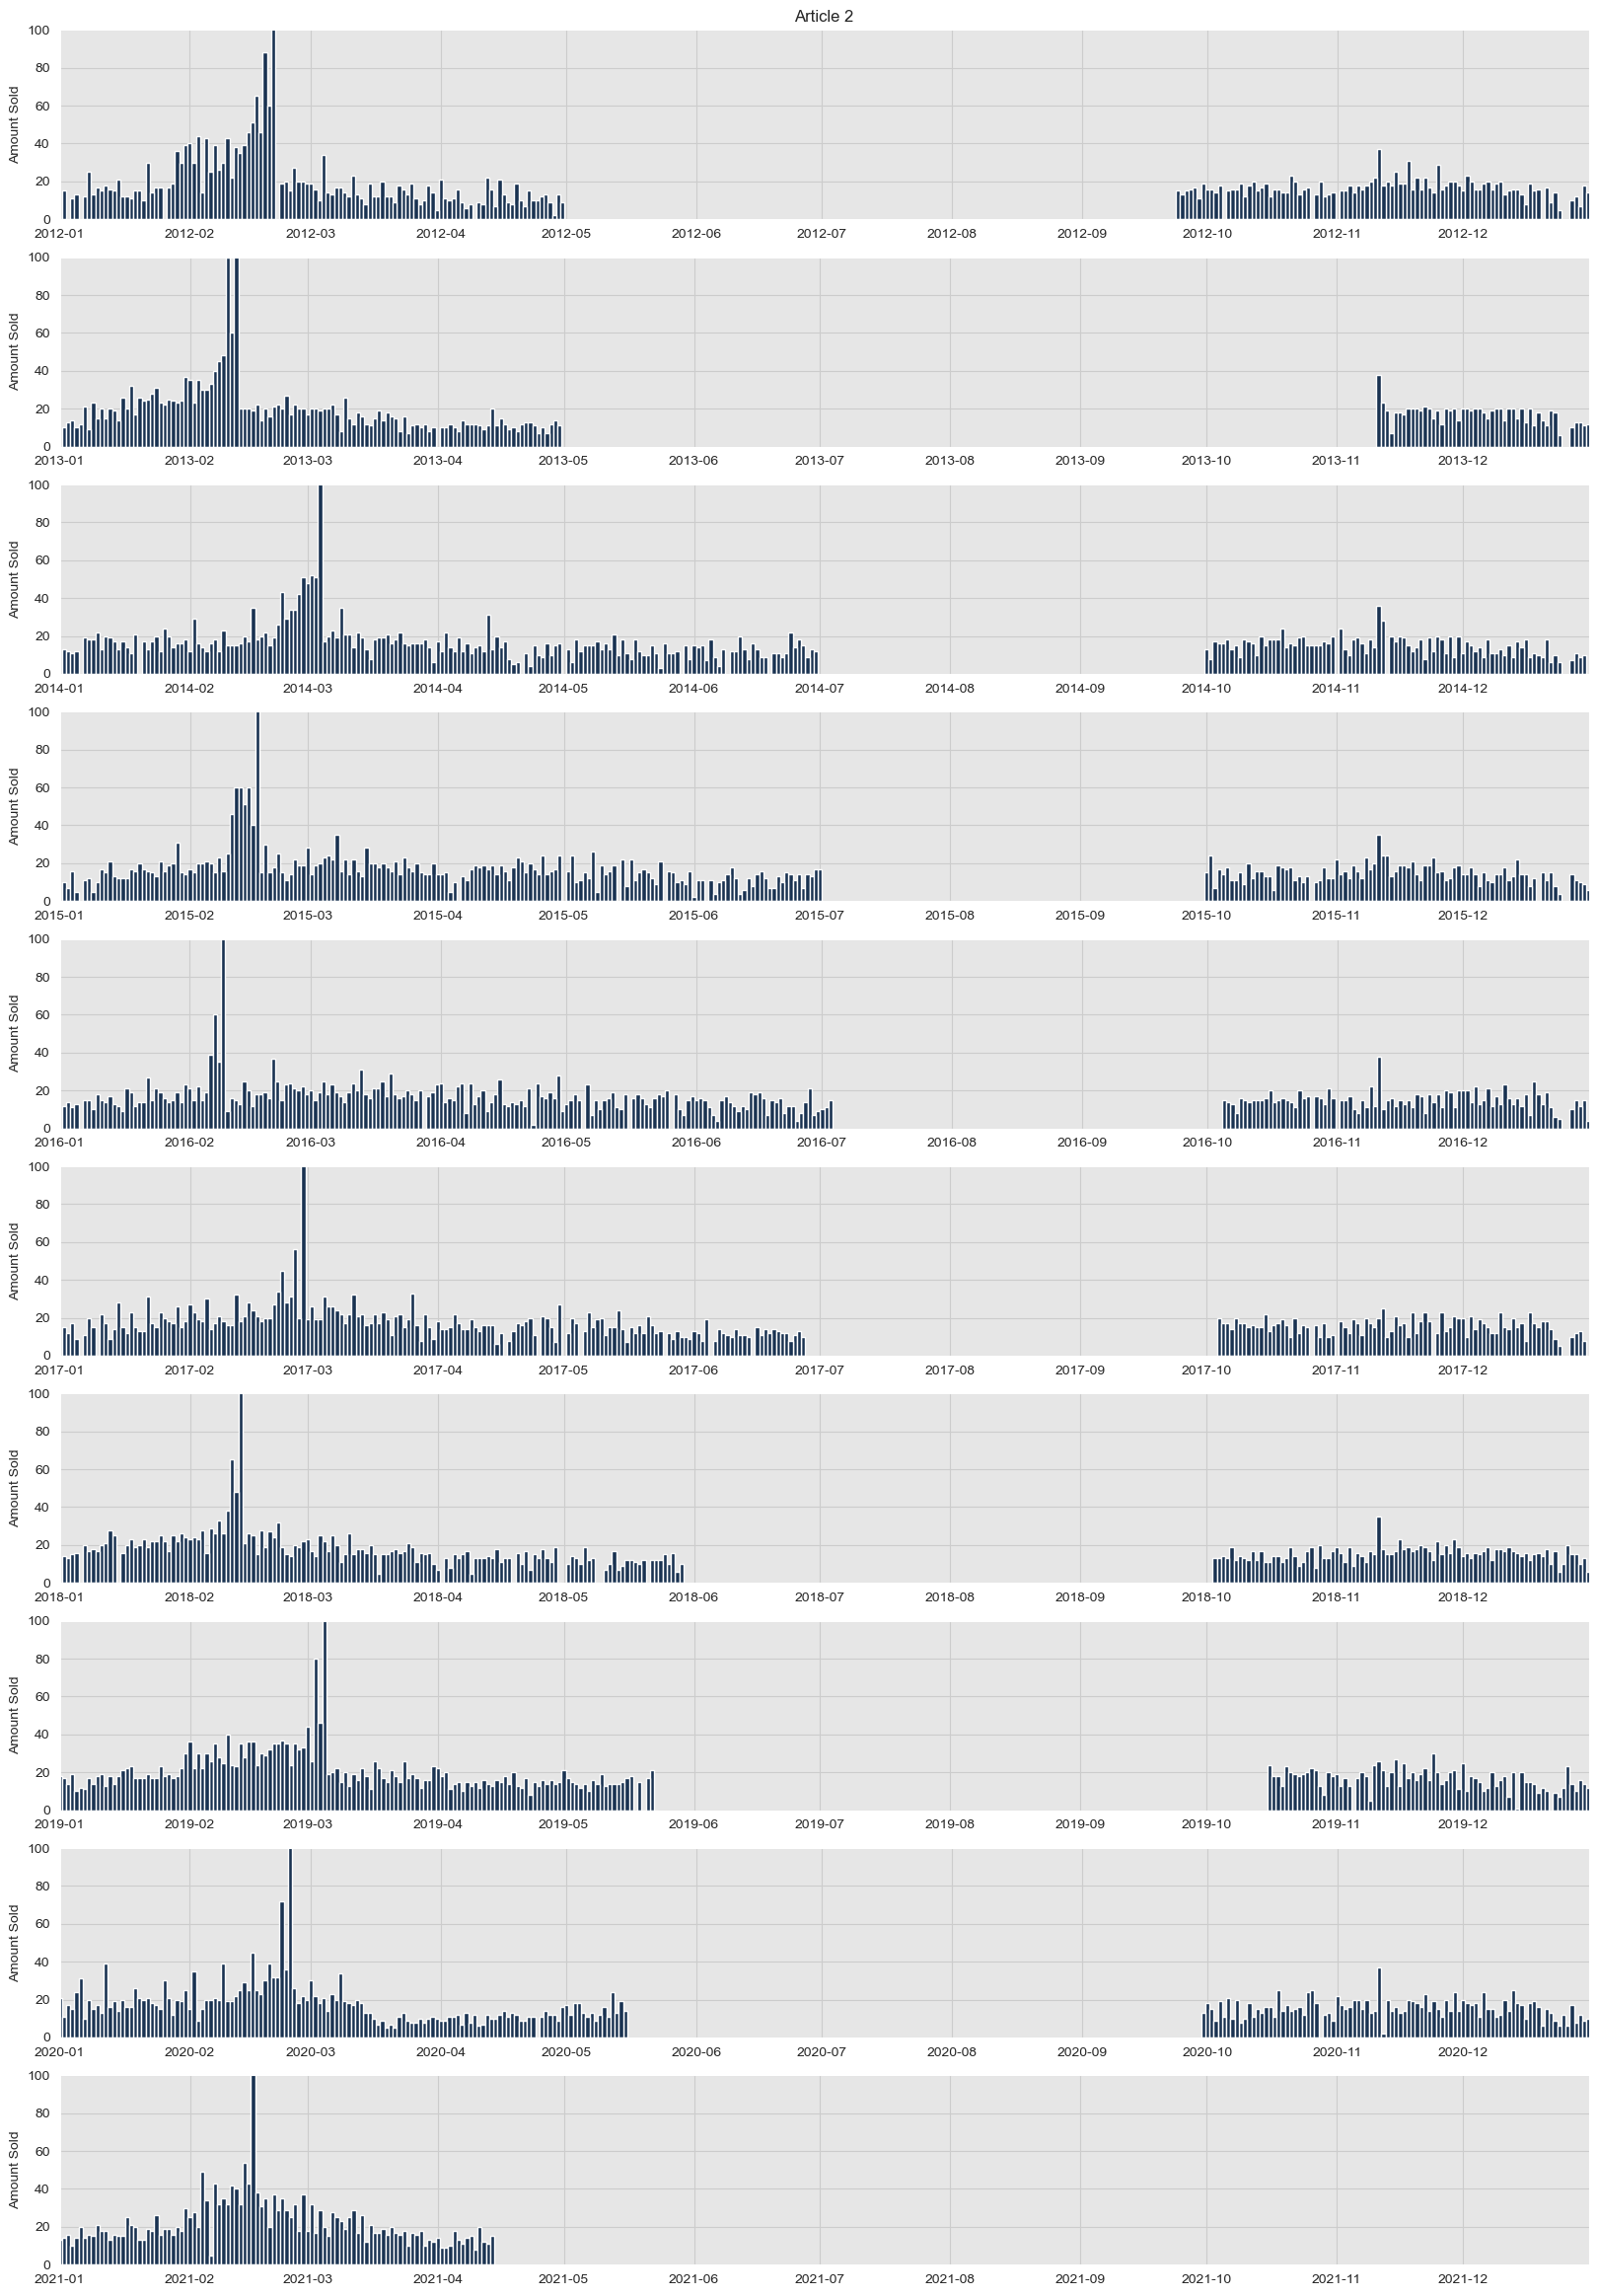

In [20]:
# Plotting Article 2 for all years
fig, ((ax1), (ax2), (ax3), (ax4), (ax5), (ax6), (ax7), (ax8), (ax9), (ax10)) = plt.subplots(10, 1, figsize=(20,30))

ax1.bar(df[(df['Year']==2012) & (df['Article_Number']==2)].Sold_On, 
        df[(df['Year']==2012) & (df['Article_Number']==2)].Amount_Sold, width=1)
ax1.set_xlim(pd.Timestamp('2012-01-01'), pd.Timestamp('2012-12-31'))
ax1.set_ylabel('Amount Sold')
ax1.set_ylim(0,100)
ax1.set_title('Article 2')

ax2.bar(df[(df['Year']==2013) & (df['Article_Number']==2)].Sold_On, 
        df[(df['Year']==2013) & (df['Article_Number']==2)].Amount_Sold, width=1)
ax2.set_xlim(pd.Timestamp('2013-01-01'), pd.Timestamp('2013-12-31'))
ax2.set_ylabel('Amount Sold')
ax2.set_ylim(0,100)

ax3.bar(df[(df['Year']==2014) & (df['Article_Number']==2)].Sold_On, 
        df[(df['Year']==2014) & (df['Article_Number']==2)].Amount_Sold, width=1)
ax3.set_xlim(pd.Timestamp('2014-01-01'), pd.Timestamp('2014-12-31'))
ax3.set_ylabel('Amount Sold')
ax3.set_ylim(0,100)

ax4.bar(df[(df['Year']==2015) & (df['Article_Number']==2)].Sold_On, 
        df[(df['Year']==2015) & (df['Article_Number']==2)].Amount_Sold, width=1)
ax4.set_xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2015-12-31'))
ax4.set_ylabel('Amount Sold')
ax4.set_ylim(0,100)

ax5.bar(df[(df['Year']==2016) & (df['Article_Number']==2)].Sold_On, 
        df[(df['Year']==2016) & (df['Article_Number']==2)].Amount_Sold, width=1)
ax5.set_xlim(pd.Timestamp('2016-01-01'), pd.Timestamp('2016-12-31'))
ax5.set_ylabel('Amount Sold')
ax5.set_ylim(0,100)

ax6.bar(df[(df['Year']==2017) & (df['Article_Number']==2)].Sold_On, 
        df[(df['Year']==2017) & (df['Article_Number']==2)].Amount_Sold, width=1)
ax6.set_xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2017-12-31'))
ax6.set_ylabel('Amount Sold')
ax6.set_ylim(0,100)

ax7.bar(df[(df['Year']==2018) & (df['Article_Number']==2)].Sold_On, 
        df[(df['Year']==2018) & (df['Article_Number']==2)].Amount_Sold, width=1)
ax7.set_xlim(pd.Timestamp('2018-01-01'), pd.Timestamp('2018-12-31'))
ax7.set_ylabel('Amount Sold')
ax7.set_ylim(0,100)

ax8.bar(df[(df['Year']==2019) & (df['Article_Number']==2)].Sold_On, 
        df[(df['Year']==2019) & (df['Article_Number']==2)].Amount_Sold, width=1)
ax8.set_xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2019-12-31'))
ax8.set_ylabel('Amount Sold')
ax8.set_ylim(0,100)

ax9.bar(df[(df['Year']==2020) & (df['Article_Number']==2)].Sold_On, 
        df[(df['Year']==2020) & (df['Article_Number']==2)].Amount_Sold, width=1)
ax9.set_xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2020-12-31'))
ax9.set_ylabel('Amount Sold')
ax9.set_ylim(0,100)

ax10.bar(df[(df['Year']==2021) & (df['Article_Number']==2)].Sold_On, 
         df[(df['Year']==2021) & (df['Article_Number']==2)].Amount_Sold, width=1)
ax10.set_xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2021-12-31'))
ax10.set_ylabel('Amount Sold')
ax10.set_ylim(0,100)

In [21]:
# Rosenmontag
# 2017: 27. Februar
# 2018: 12. Februar
# 2019: 04. März
# 2020: 24. Februar
# 2021: 15. Februar

In [22]:
df_baseline = df[(df['Article_Number']==1)&(df['Year']==2018)][['Sold_On', 'Amount_Sold']]
df_baseline = df_baseline.set_index('Sold_On').sort_index()
df_baseline = df_baseline.loc['2018-01-01':'2018-05-31']
df_baseline.rename(columns = {'Amount_Sold':'Amount_Sold_Test'}, inplace = True)
df_baseline.head()

,Amount_Sold_Test
Sold_On,
2018-01-15,61
2018-01-16,60
2018-01-17,64
2018-01-18,66
2018-01-19,72


In [23]:
df1=df[(df['Article_Number']==2)&(df['Ratio_DelSol']>1)]
df2=df1[['Sold_On', 'Amount_Sold']]
df2=df2.set_index('Sold_On').sort_index()
#df2=df2.loc['2020-01-01':'2020-05-31']
df2.head()

,Amount_Sold
Sold_On,
2012-01-04,11
2012-01-05,13
2012-01-09,13
2012-01-10,17
2012-01-12,18


<AxesSubplot:xlabel='Sold_On'>

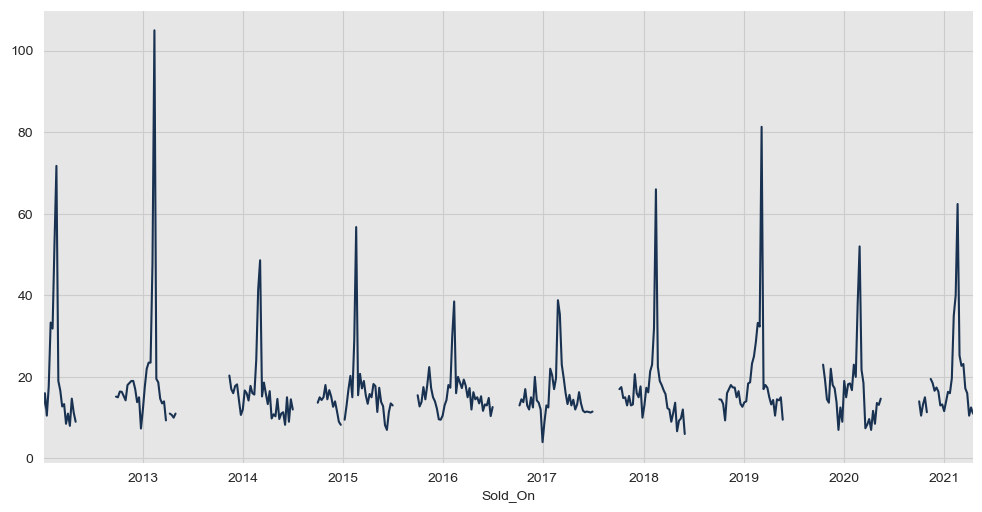

In [24]:
df2.Amount_Sold.resample('W').mean().plot()

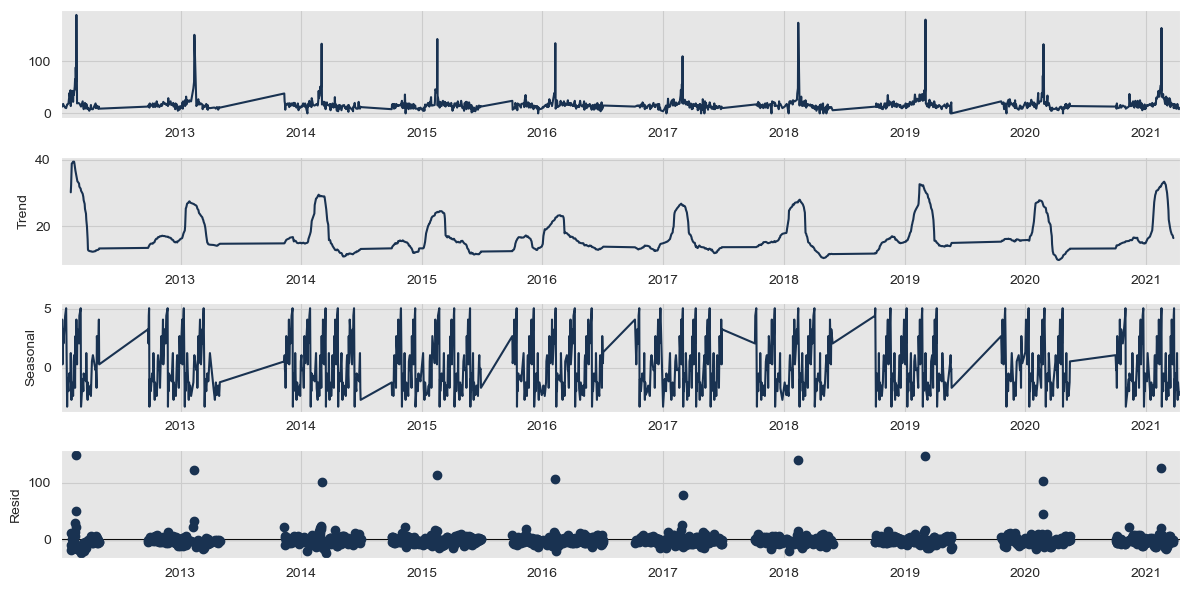

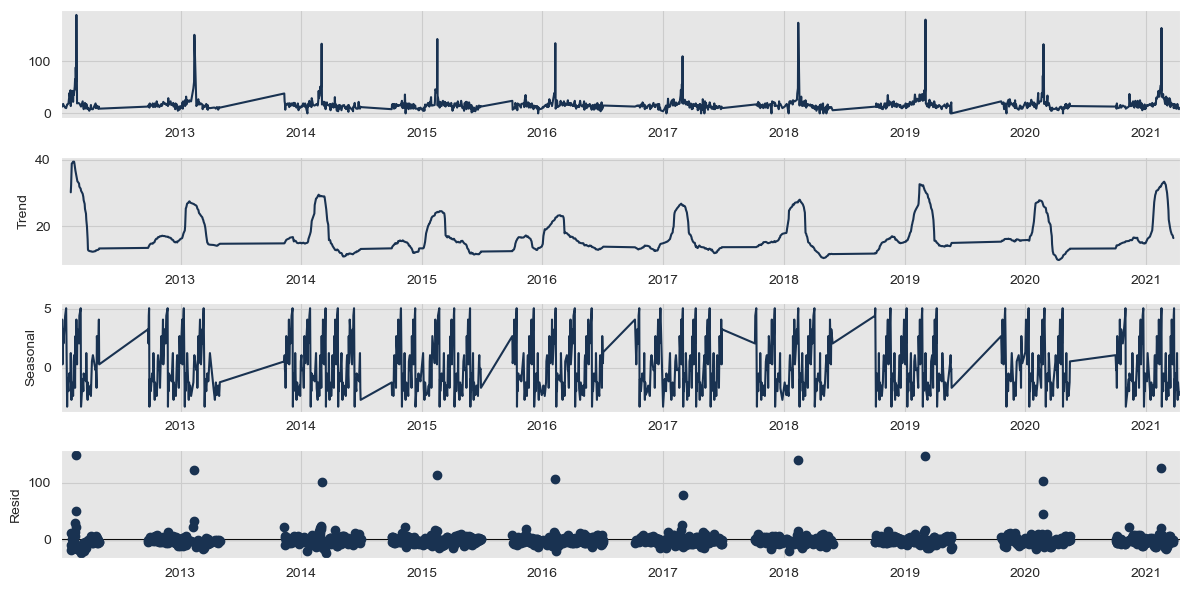

In [25]:
result = seasonal_decompose(df2, model='additive', period=30)
result.plot()